# Gravitation in PHANTOM
**Test of PHANTOM long-range interaction acceleration**

<!-- @article{PriceEtAl2018,
  title = {{$<$}scp{$>$}{{Phantom}}{$<$}/Scp{$>$}: {{A Smoothed Particle Hydrodynamics}} and {{Magnetohydrodynamics Code}} for {{Astrophysics}}},
  author = {Price, Daniel J. and Wurster, James and Tricco, Terrence S. and Nixon, Chris and Toupin, Stéven and Pettitt, Alex and Chan, Conrad and Mentiplay, Daniel and Laibe, Guillaume and Glover, Simon and Dobbs, Clare and Nealon, Rebecca and Liptai, David and Worpel, Hauke and Bonnerot, Clément and Dipierro, Giovanni and Ballabio, Giulia and Ragusa, Enrico and Federrath, Christoph and Iaconi, Roberto and Reichardt, Thomas and Forgan, Duncan and Hutchison, Mark and Constantino, Thomas and Ayliffe, Ben and Hirsh, Kieran and Lodato, Giuseppe},
  date = {2018},
  journaltitle = {Publications of the Astronomical Society of Australia},
  shortjournal = {Publ. Astron. Soc. Aust.},
  volume = {35},
  number = {2018},
  eprint = {1702.03930},
  eprinttype = {arxiv},
  pages = {e031},
  issn = {1323-3580},
  doi = {10.1017/pasa.2018.25},
  url = {https://www.cambridge.org/core/product/identifier/S1323358018000255/type/journal_article},
  abstract = {We present Phantom , a fast, parallel, modular, and low-memory smoothed particle hydrodynamics and magnetohydrodynamics code developed over the last decade for astrophysical applications in three dimensions. The code has been developed with a focus on stellar, galactic, planetary, and high energy astrophysics, and has already been used widely for studies of accretion discs and turbulence, from the birth of planets to how black holes accrete. Here we describe and test the core algorithms as well as modules for magnetohydrodynamics, self-gravity, sink particles, dust–gas mixtures, H 2 chemistry, physical viscosity, external forces including numerous galactic potentials, Lense–Thirring precession, Poynting–Robertson drag, and stochastic turbulent driving. Phantom is hereby made publicly available.},
  langid = {english},
  keywords = {★, accretion, accretion disks, gravitaion, hydrodynamics, SM: general, agnetohydrodynamics (MHD), methods: numerical, PHANTOM, SPH},
  annotation = {262 citations (Crossref) [2024-03-19]},
  file = {/Users/marat/Yandex.Disk.localized/Documents/Zotero/storage/UB8DW3WQ/Price et al - 2018 - scpPhantom-scp - A Smoothed Particle Hydrodynamics and Magnetohydrodynamics.pdf}
} -->

In [518]:
(* https://mathematica.stackexchange.com/questions/850/how-do-i-clear-all-user-defined-symbols/861#861 *)
<< Utilities`CleanSlate`
CleanSlate[];
ClearAll["Global`*"]
(* ClearSystemCache[] *)
(* https://mathematica.stackexchange.com/questions/111605/quit-vs-clearallglobal *)
if[Length[Names["Global`*"]] > 0, Remove["Global`*"]];

(* PacletInstall[
    "TensorSimplify",
    "Site" -> "http://raw.githubusercontent.com/carlwoll/TensorSimplify/master"
]
<<TensorSimplify` *)

  (CleanSlate) Contexts purged: {Global`}
  (CleanSlate) Approximate kernel memory recovered: 1236 Kb


## Einstein Summation

In [526]:
ClearAll@EinsteinSummation

EinsteinSummation[in_List, arrays_] := Module[
  {res =
    isum[in -> Cases[Tally @ Flatten @ in, {_, 1}][[All, 1]], arrays]},
  res /; res =!= $Failed
  ]

EinsteinSummation[in_List -> out_, arrays_] := Module[
  {res = isum[in -> out, arrays]},
  res /; res =!= $Failed
  ]

isum[in_List -> out_, arrays_List] := Catch@Module[
  {indices, contracted, uncontracted, contractions, transpose},
  If[Length[in] != Length[arrays],
    Message[EinsteinSummation::length, Length[in], Length[arrays]];
    Throw[$Failed]];
  MapThread[
    If[IntegerQ@TensorRank[#1] && Length[#1] != TensorRank[#2],
      Message[EinsteinSummation::shape, #1, #2];
      Throw[$Failed]] &, {in, arrays}];
  indices = Tally[Flatten[in, 1]];
  If[DeleteCases[indices, {_, 1 | 2}] =!= {},
    Message[EinsteinSummation::repeat,
      Cases[indices, {x_, Except[1 | 2]} :> x]];
    Throw[$Failed]];
  uncontracted = Cases[indices, {x_, 1} :> x];
  If[Sort[uncontracted] =!= Sort[out],
    Message[EinsteinSummation::output, uncontracted, out];
    Throw[$Failed]];
  contracted = Cases[indices, {x_, 2} :> x];
  contractions = Flatten[Position[Flatten[in, 1], #]] & /@ contracted;
  transpose = FindPermutation[uncontracted, out];
  Activate@
    TensorTranspose[
      TensorContract[Inactive[TensorProduct] @@ arrays, contractions],
      transpose]]

EinsteinSummation::length =
  "Number of index specifications (`1`) does not match the number of \
tensors (`2`)";
EinsteinSummation::shape =
  "Index specification `1` does not match the tensor rank of `2`";
EinsteinSummation::repeat =
  "Index specifications `1` are repeated more than twice";
EinsteinSummation::output =
  "The uncontracted indices don't match the desired output";

In [534]:
(* different variants *)
(* Norm[dx]^2 *)
(* SquareLength[x_] := EinsteinSummation[{{i}, {i}}, {x, x}] *)
SquareLength[x_] := x.x

## Test of partice-node force

### Definitions of vectors

In [538]:
(* r is a distance between particle and node *)
(* M is a mass of the node *)
$Assumptions = {
  _ \[Element] Reals,
  {r, M} \[Element] PositiveReals
};

(* rv is the relative position vector *)
rv = Array[Subscript[r, ##] &, {3}];

(* corresponding unit vector *)
(* ur = Normalize[rv] *)
ur = rv/Sqrt[SquareLength[rv]];

(* unit vector rv with hat *)
(* h means hat *)
urh = Array[Subscript[OverHat[r], ##] &, {3}];

### Quadrupole moments

In [549]:
(* Q is a symmetric tensor, only six independent quantities need to be stored (Qxx, Qxy, Qxz, Qyy, Qyz and Qzz) *)
(* https://mathematica.stackexchange.com/questions/127513/how-to-create-a-symmetric-symbolic-tensor *)
Qij = Normal@ SymmetrizedArray[{i_, j_} -> Subscript[Q, {i, j}], {3, 3}, Symmetric[{1, 2}]];
(* SymmetricMatrixQ[Qij] *)

Qi = EinsteinSummation[{{j}, {i, j}}, {ur, Qij}];
Qih = EinsteinSummation[{{j}, {i, j}}, {urh, Qij}];

In [555]:
ClearAll@DoCollapse
DoCollapse[f_] :=
  Module[{func = f},
    Expand[
      ReplaceAll[
        func
        , {
        SquareLength[rv] -> r*r
        , rv[[1]] -> urh[[1]]*r
        , rv[[2]] -> urh[[2]]*r
        , rv[[3]] -> urh[[3]]*r
        }
      ]
    ] // MatrixForm
  ]

ClearAll@DoExpand
DoExpand[f_] :=
  Module[{func = f},
    Expand[
      ReplaceAll[
        func
        , {
        Q -> urh.Qih
        , Subscript[Q, 1] -> Qih[[1]]
        , Subscript[Q, 2] -> Qih[[2]]
        , Subscript[Q, 3] -> Qih[[3]]
        (* https://mathematica.stackexchange.com/questions/192416/how-to-avoid-replace-substituting-subscripts *)
        , s_Subscript :> s
        }
      ]
    ] // MatrixForm
  ]

### Eq. 222

^
  M r
     1
-(----)
    2
   r

    ^
  M r
     2
-(----)
    2
   r

    ^
  M r
     3
-(----)
    2
   r
0
         ^
     5 Q r
          1
Q  - ------
 1     2
-----------
     4
    r

         ^
     5 Q r
          2
Q  - ------
 2     2
-----------
     4
    r

         ^
     5 Q r
          3
Q  - ------
 3     2
-----------
     4
    r
0
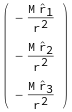
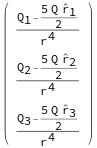

In [565]:
(* from PHANTOM eq. 222 *)
aMPhantom = -M/r^2*urh;
aQPhantom = 1/r^4*Array[(Subscript[Q, #] - 5/2*urh[[#]]*Q) &, {3}];

(* symbolic test *)
aM = -M/SquareLength[rv]*ur;
aQ = 1/SquareLength[rv]^2*(Qi - 5/2*ur*(ur.Qi));

aMPhantom // MatrixForm
FullSimplify[DoExpand[aMPhantom] - DoCollapse[aM]]

aQPhantom // MatrixForm
FullSimplify[DoExpand[aQPhantom] - DoCollapse[aQ]]

### Eq. 226

^ 2        ^  ^             ^  ^
M (-1 + 3 r  )   3 M r  r         3 M r  r
           1          1  2             1  3
--------------   ---------        ---------
       3             3                3
      r             r                r

    ^  ^                   ^ 2        ^  ^
3 M r  r         M (-1 + 3 r  )   3 M r  r
     1  2                   2          2  3
---------        --------------   ---------
    3                   3             3
   r                   r             r

    ^  ^             ^  ^                   ^ 2
3 M r  r         3 M r  r         M (-1 + 3 r  )
     1  3             2  3                   3
---------        ---------        --------------
    3                3                   3
   r                r                   r
0
                                  ^ 2                                         ^  ^
                               35 r                                      35 Q r  r
                ^         5        1                      ^         ^          1  2
Q       - 10 Q  r  + Q (-(-) + ------)     Q       - 5 Q  r  - 5 Q  r  + ----------
 {1, 1}       1  1        2      2          {1, 2}      2  1      1  2       2
--------------------------------------     ----------------------------------------
                   5                                           5
                  r                                           r
 
                                           ^  ^
                                      35 Q r  r
                       ^         ^          1  3
        Q       - 5 Q  r  - 5 Q  r  + ----------
         {1, 3}      3  1      1  3       2
        ----------------------------------------
                            5
>                          r

                                   ^  ^                                      ^ 2
                              35 Q r  r                                   35 r
               ^         ^          1  2                   ^         5        2
Q       - 5 Q  r  - 5 Q  r  + ----------   Q       - 10 Q  r  + Q (-(-) + ------)
 {1, 2}      2  1      1  2       2         {2, 2}       2  2        2      2
----------------------------------------   --------------------------------------
                    5                                         5
                   r                                         r
 
                                           ^  ^
                                      35 Q r  r
                       ^         ^          2  3
        Q       - 5 Q  r  - 5 Q  r  + ----------
         {2, 3}      3  2      2  3       2
        ----------------------------------------
                            5
>                          r

                                   ^  ^                                       ^  ^
                              35 Q r  r                                  35 Q r  r
               ^         ^          1  3                  ^         ^          2  3
Q       - 5 Q  r  - 5 Q  r  + ----------   Q       - 5 Q  r  - 5 Q  r  + ----------
 {1, 3}      3  1      1  3       2         {2, 3}      3  2      2  3       2
----------------------------------------   ----------------------------------------
                    5                                          5
                   r                                          r
 
                                          ^ 2
                                       35 r
                        ^         5        3
        Q       - 10 Q  r  + Q (-(-) + ------)
         {3, 3}       3  3        2      2
        --------------------------------------
                           5
>                         r
0
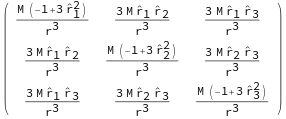
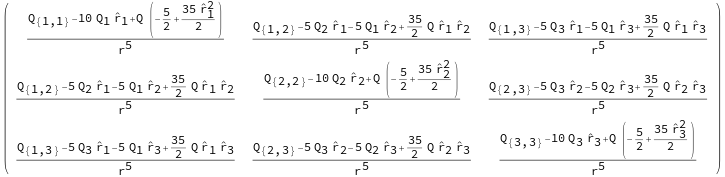

In [575]:
(* from PHANTOM eq. 226 *)
daMPhantom = M/r^3*Array[3*urh[[#]]*urh[[#2]] - KroneckerDelta[#, #2] &, {3, 3}];
daQPhantom = 1/r^5*Array[
  Qij[[#, #2]]
  + (35/2*urh[[#]]*urh[[#2]] - 5/2*KroneckerDelta[#, #2])*Q
  - 5*urh[[#]]*Subscript[Q, #2] - 5*urh[[#2]]*Subscript[Q, #]
  &, {3, 3}];

(* symbolic test *)
daM = D[aM, {rv}];
daQ = D[aQ, {rv}];

daMPhantom // MatrixForm
FullSimplify[DoCollapse[daM] - DoExpand[daMPhantom]]

daQPhantom // MatrixForm
FullSimplify[DoCollapse[daQ] - DoExpand[daQPhantom]]

### Eq. 227

^      ^ 3            ^      ^ 2 ^            ^      ^ 2 ^
-3 M (-3 r  + 5 r  )    -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r   r )
          1      1              2      1   2            3      1   3
--------------------    ---------------------   ---------------------
          4                       4                       4
         r                       r                       r
       ^      ^ 2 ^            ^      ^  ^ 2          ^  ^  ^
-3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )   -15 M r  r  r
        2      1   2            1      1  2            1  2  3
---------------------   ---------------------   --------------
          4                       4                    4
         r                       r                    r
       ^      ^ 2 ^           ^  ^  ^                  ^      ^  ^ 2
-3 M (-r  + 5 r   r )   -15 M r  r  r           -3 M (-r  + 5 r  r  )
        3      1   3           1  2  3                  1      1  3
---------------------   --------------          ---------------------
          4                    4                          4
         r                    r                          r

       ^      ^ 2 ^            ^      ^  ^ 2          ^  ^  ^
-3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )   -15 M r  r  r
        2      1   2            1      1  2            1  2  3
---------------------   ---------------------   --------------
          4                       4                    4
         r                       r                    r
       ^      ^  ^ 2             ^      ^ 3            ^      ^ 2 ^
-3 M (-r  + 5 r  r  )   -3 M (-3 r  + 5 r  )    -3 M (-r  + 5 r   r )
        1      1  2               2      2              3      2   3
---------------------   --------------------    ---------------------
          4                       4                       4
         r                       r                       r
      ^  ^  ^                  ^      ^ 2 ^            ^      ^  ^ 2
-15 M r  r  r           -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )
       1  2  3                  3      2   3            2      2  3
--------------          ---------------------   ---------------------
       4                          4                       4
      r                          r                       r

       ^      ^ 2 ^           ^  ^  ^                  ^      ^  ^ 2
-3 M (-r  + 5 r   r )   -15 M r  r  r           -3 M (-r  + 5 r  r  )
        3      1   3           1  2  3                  1      1  3
---------------------   --------------          ---------------------
          4                    4                          4
         r                    r                          r
      ^  ^  ^                  ^      ^ 2 ^            ^      ^  ^ 2
-15 M r  r  r           -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )
       1  2  3                  3      2   3            2      2  3
--------------          ---------------------   ---------------------
       4                          4                       4
      r                          r                       r
       ^      ^  ^ 2           ^      ^  ^ 2             ^      ^ 3
-3 M (-r  + 5 r  r  )   -3 M (-r  + 5 r  r  )   -3 M (-3 r  + 5 r  )
        1      1  3             2      2  3               3      3
---------------------   ---------------------   --------------------
          4                       4                       4
         r                       r                       r
0
                                                                                   ^
                                                                              35 Q r
                                                                                    2
                                                                     (-5 Q  + ------- - 
                                                                          2      2
                                                                      
            
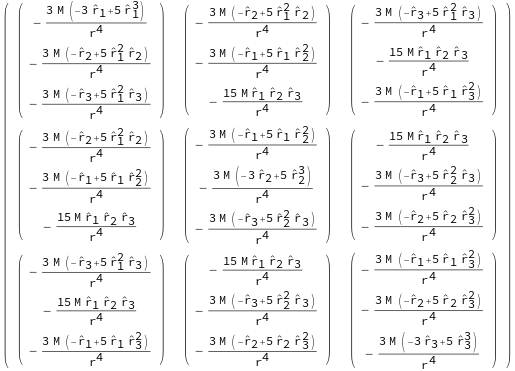
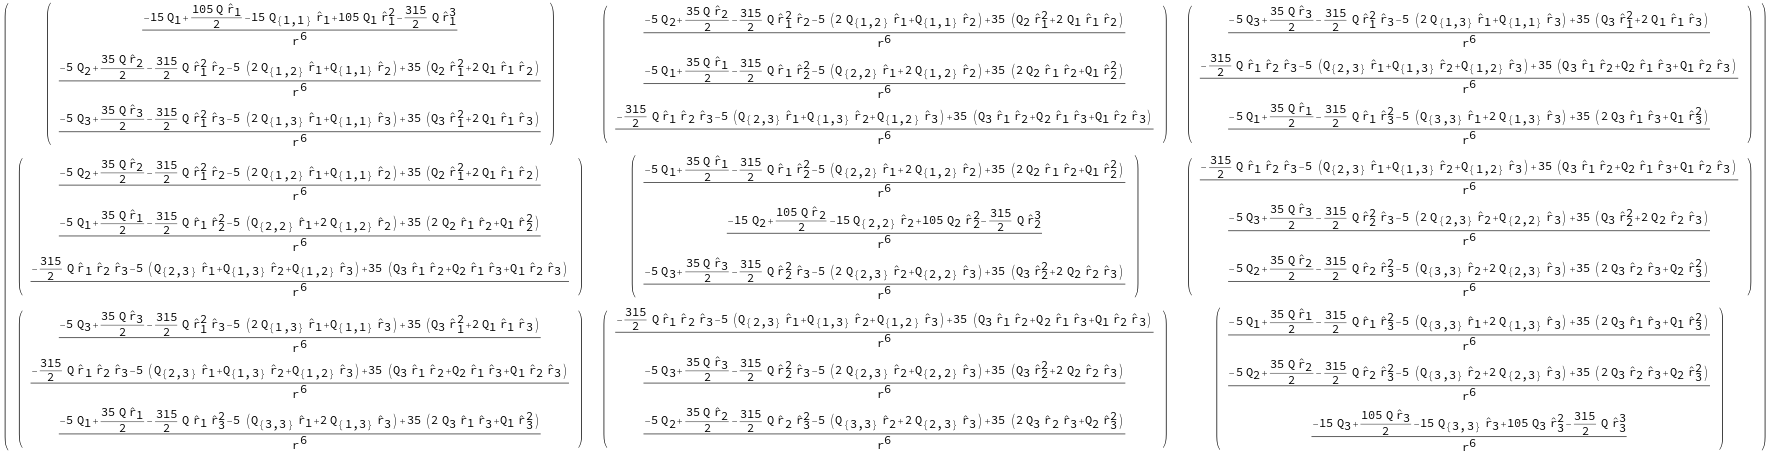

In [585]:
(* from PHANTOM eq. 227 *)
d2aMPhantom = -3*M/r^4*Array[
  5*urh[[#]]*urh[[#2]]*urh[[#3]]
  - KroneckerDelta[#2, #3]*urh[[#]]
  - KroneckerDelta[#, #3]*urh[[#2]]
  - KroneckerDelta[#, #2]*urh[[#3]]
  &, {3, 3, 3}
  ];
d2aQPhantom = 1/r^6*Array[
  - 5*(urh[[#3]]*Qij[[#, #2]] + urh[[#]]*Qij[[#2, #3]] + urh[[#2]]*Qij[[#, #3]])
  - 315/2*urh[[#]]*urh[[#2]]*urh[[#3]]*Q
  + 35/2*(KroneckerDelta[#, #2]*urh[[#3]] + KroneckerDelta[#, #3]*urh[[#2]] + KroneckerDelta[#2, #3]*urh[[#]])*Q
  + 35*(urh[[#2]]*urh[[#3]]*Subscript[Q, #] + urh[[#]]*urh[[#3]]*Subscript[Q, #2] + urh[[#]]*urh[[#2]]*Subscript[Q, #3])
  - 5*(KroneckerDelta[#, #2]*Subscript[Q, #3] + KroneckerDelta[#, #3]*Subscript[Q, #2] + KroneckerDelta[#2, #3]*Subscript[Q, #])
  &, {3, 3, 3}
  ];

(* symbolic test *)
d2aM = D[daM, {rv}];
d2aQ = D[daQ, {rv}];

d2aMPhantom // MatrixForm
FullSimplify[DoCollapse[d2aM] - DoExpand[d2aMPhantom]]

d2aQPhantom // MatrixForm
FullSimplify[DoCollapse[d2aQ] - DoExpand[d2aQPhantom]]

### Conclusion: the formulas are <span style="color:green">correct!</span>

## Checking the symmetry of the node-node interaction force

**Let's take the mass of the particle as unit**

**All particles have equal masses which is enforced in PHANTOM**

In [589]:
(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

(* number of particles in each nodes *)
Np = {2, 2};
(* number of nodes *)
Nn = Length[Np];
(* maximum number of paticles *)
maxNp = Max[Np];

### Definition of dx

Δx         Δx         Δx
  1,1,1      1,1,2      1,1,3

-Δx        -Δx        -Δx
   1,1,1      1,1,2      1,1,3
Δx         Δx         Δx
  2,1,1      2,1,2      2,1,3

-Δx        -Δx        -Δx
   2,1,1      2,1,2      2,1,3
{2, 2, 3}
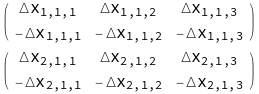

In [601]:
ClearAll@dx
ClearAll@DefineDx

DefineDx[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    dx0
  },

  (* dx the relative distance of each particle from the node centre of mass *)
  dx0 = Array[Subscript[\[CapitalDelta]x, ##] &, {Nn, maxNp, 3}];
  (* by determining the center of mass of the node *)
  Do[
    dx0[[n, Np[[n]]]] =
    If[
      Np[[n]] <= 1
      , {0, 0, 0}
      , - Sum[dx0[[n, p]], {p, Np[[n]] - 1}]
    ]
    , {n, 1, Nn}
  ];

  dx0
]

dx = DefineDx[Np];

Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]
(* node n, p from n, components dx *)
Dimensions[dx]

### Redefinition of r

r
0          {1, 2}

r
 {1, 2}   0
              ^
              r
0              {1, 2, 1}
              ^
              r
0              {1, 2, 2}
              ^
              r
0              {1, 2, 3}

 ^
-r
  {1, 2, 1}   0
 ^
-r
  {1, 2, 2}   0
 ^
-r
  {1, 2, 3}   0
{_ ∈ Reals, (r       | r      ) ∈ Reals && r       > 0 && r       > 0, 
              {1, 2}    {1, 2}              {1, 2}         {1, 2}
 
    ^         2   ^         2   ^         2
>   r           + r           + r           == 1}
     {1, 2, 1}     {1, 2, 2}     {1, 2, 3}
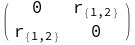
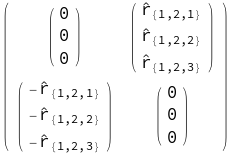

In [610]:
(* distance between nodes *)
ClearAll@r
ClearAll@DefineR

DefineR[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    rnm0,
    urh0
  },

  rnm0 = Normal@ SymmetrizedArray[{i_, j_} -> Subscript[r, {i, j}], {Nn, Nn}, Symmetric[{1, 2}]];

  (* https://mathematica.stackexchange.com/questions/92666/how-to-zero-or-replace-the-diagonal-of-a-square-matrix *)
  (* rnm0 = ReplacePart[rnm0, {i_, i_} -> 0]; *)
  rnm0 = UpperTriangularize[rnm0, 1] + LowerTriangularize[rnm0, -1];

  (* unit vector r with hat *)
  (* h means hat *)
  urh0 = Normal@ SymmetrizedArray[{i_, j_, k_} -> Subscript[OverHat[r], {i, j, k}], {Nn, Nn, 3}, Antisymmetric[{1, 2}]];

  $Assumptions = {
    (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
    _ \[Element] Reals,
    (* https://mathematica.stackexchange.com/questions/220317/how-to-best-add-assumption-that-many-variables-are-positive *)
    SparseArray[rnm0]["NonzeroValues"] \[Element] PositiveReals
  };
  $Assumptions = Join[
    $Assumptions, Flatten@Table[urh0[[n, m, 1]]^2 + urh0[[n, m, 2]]^2 + urh0[[n, m, 3]]^2 == 1, {n, Nn}, {m, n+1, Nn}]
  ];

  {rnm0, urh0}
]

rAll = DefineR[Np];
rnm = rAll[[1]];
rnm // MatrixForm
urh = rAll[[2]];
urh // MatrixForm

$Assumptions

### Redefinition of quadrupole moments

2            2            2
4 Δx       - 2 Δx       - 2 Δx          6 Δx      Δx
    1,1,1        1,1,2        1,1,3         1,1,1   1,1,2
 

     6 Δx      Δx
>        1,1,1   1,1,3

                                                  2            2            2
6 Δx      Δx                            -2 Δx       + 4 Δx       - 2 Δx
    1,1,1   1,1,2                            1,1,1        1,1,2        1,1,3
 

     6 Δx      Δx
>        1,1,2   1,1,3


6 Δx      Δx                            6 Δx      Δx
    1,1,1   1,1,3                           1,1,2   1,1,3
 
               2            2            2
     -2 Δx       - 2 Δx       + 4 Δx
>         1,1,1        1,1,2        1,1,3
         2            2            2
4 Δx       - 2 Δx       - 2 Δx          6 Δx      Δx
    2,1,1        2,1,2        2,1,3         2,1,1   2,1,2
 

     6 Δx      Δx
>        2,1,1   2,1,3

                                                  2            2            2
6 Δx      Δx                            -2 Δx       + 4 Δx       - 2 Δx
    2,1,1   2,1,2                            2,1,1        2,1,2        2,1,3
 

     6 Δx      Δx
>        2,1,2   2,1,3


6 Δx      Δx                            6 Δx      Δx
    2,1,1   2,1,3                           2,1,2   2,1,3
 
               2            2            2
     -2 Δx       - 2 Δx       + 4 Δx
>         2,1,1        2,1,2        2,1,3
{2, 3, 3}
True
True
      ^                              ^
    6 r          Δx      Δx      + 6 r          Δx      Δx      + 
       {1, 2, 2}   2,1,1   2,1,2      {1, 2, 3}   2,1,1   2,1,3
     
        ^                    2            2            2
    >   r          (4 Δx       - 2 Δx       - 2 Δx      )
         {1, 2, 1}      2,1,1        2,1,2        2,1,3
      ^                              ^
    6 r          Δx      Δx      + 6 r          Δx      Δx      + 
       {1, 2, 1}   2,1,1   2,1,2      {1, 2, 3}   2,1,2   2,1,3
     
        ^                     2            2            2
    >   r          (-2 Δx       + 4 Δx       - 2 Δx      )
         {1, 2, 2}       2,1,1        2,1,2        2,1,3
      ^                              ^
    6 r          Δx      Δx      + 6 r          Δx      Δx      + 
       {1, 2, 1}   2,1,1   2,1,3      {1, 2, 2}   2,1,2   2,1,3
     
0       ^                     2            2            2
0   >   r          (-2 Δx       - 2 Δx       + 4 Δx      )
0        {1, 2, 3}       2,1,1        2,1,2        2,1,3

   ^                              ^
-6 r          Δx      Δx      - 6 r          Δx      Δx      - 
    {1, 2, 2}   1,1,1   1,1,2      {1, 2, 3}   1,1,1   1,1,3
 
    ^                    2            2            2
>   r          (4 Δx       - 2 Δx       - 2 Δx      )
     {1, 2, 1}      1,1,1        1,1,2        1,1,3
   ^                              ^
-6 r          Δx      Δx      - 6 r          Δx      Δx      - 
    {1, 2, 1}   1,1,1   1,1,2      {1, 2, 3}   1,1,2   1,1,3
 
    ^                     2            2            2
>   r          (-2 Δx       + 4 Δx       - 2 Δx      )
     {1, 2, 2}       1,1,1        1,1,2        1,1,3
   ^                              ^
-6 r          Δx      Δx      - 6 r          Δx      Δx      - 
    {1, 2, 1}   1,1,1   1,1,3      {1, 2, 2}   1,1,2   1,1,3
 
    ^                     2            2            2             0
>   r          (-2 Δx       - 2 Δx       + 4 Δx      )            0
     {1, 2, 3}       1,1,1        1,1,2        1,1,3              0
{2, 2, 3}
0   ^             ^                              ^
    r          (6 r          Δx      Δx      + 6 r          Δx      Δx      + 
     {1, 2, 1}     {1, 2, 2}   2,1,1   2,1,2      {1, 2, 3}   2,1,1   2,1,3
     
           ^                    2            2            2
    >      r          (4 Δx       - 2 Δx       - 2 Δx      )) + 
            {1, 2, 1}      2,1,1        2,1,2        2,1,3
     
        ^             ^                              ^
    >   r          (6 r          Δx      Δx      + 6 r    
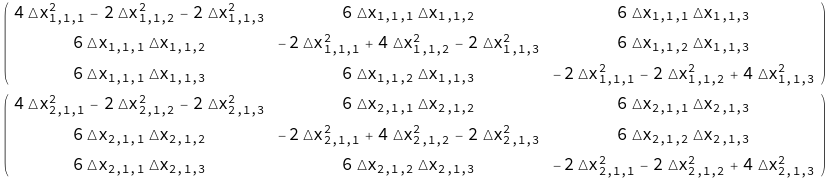
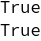
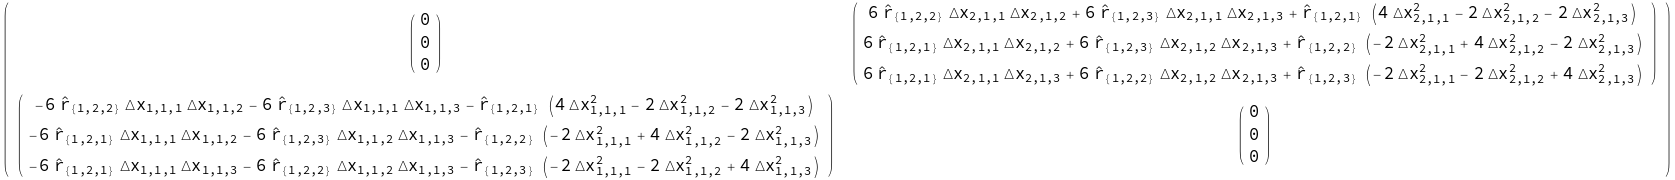
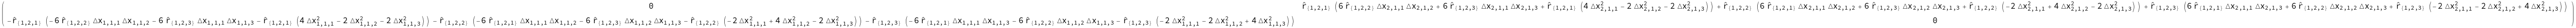

In [619]:
ClearAll@Qij
ClearAll@DefineQij

DefineQij[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    Qijp,
    Qij0,
    Qi0Full,
    Qi0,
    Q0Full,
    Q0
  },

  Qijp = Array[3*dx[[#, #2, #3]]*dx[[#, #2, #4]] - SquareLength[dx[[#, #2]]]*KroneckerDelta[#3, #4] &, {Nn, maxNp, 3, 3}];
  Qij0 = Array[Subscript[Q, ##] &, {Nn, 3, 3}];
  Do[Qij0[[n]] = ParallelSum[Qijp[[n, p]], {p, Np[[n]]}], {n, 1, Nn}];

  Qi0Full = EinsteinSummation[{{n, m1, j}, {m2, i, j}}, {urh, Qij0}];
  (* get diagonal *)
  Qi0 = ParallelTable[Qi0Full[[n, m, m]], {n, 1, Nn}, {m, 1, Nn}];

  Q0Full = EinsteinSummation[{{n1, m1, i}, {n2, m2, j}, {m3, i, j}}, {urh, urh, Qij0}];
  (* get diagonal *)
  Q0 = ParallelTable[Q0Full[[n, m, n, m, m]], {n, 1, Nn}, {m, 1, Nn}];

  {Qij0, Qi0, Q0}
]

QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]
(* node n, components q, components q *)
Dimensions[Qij]

(* Q is a symmetric tensor, only six independent quantities need to be stored (Qxx, Qxy, Qxz, Qyy, Qyz and Qzz) *)
Column[Table[SymmetricMatrixQ[Qij[[n]]] // MatrixForm, {n, 1, Nn}]]

Qi = QijAll[[2]];
Qi // MatrixForm
(* node n, node m, components q *)
Dimensions[Qi]

Q = QijAll[[3]];
Q // MatrixForm
(* node n, node m *)
Dimensions[Q]


### Node_1 <- Node_2 =? Node_2 <- Node_1

#### Eq. 222

In [638]:
(* NB: without r *)

ClearAll@aMPhantom
aMPhantom[Np_] := Array[-Np[[#2]]*urh[[#, #2]] &, {Length[Np], Length[Np]}];

ClearAll@aQPhantom
aQPhantom[Np_] := Array[(Qi[[#, #2, #3]] - 5/2*urh[[#, #2, #3]]*Q[[#, #2]]) &, {Length[Np], Length[Np], 3}];

(* node n, node m, components a *)
Dimensions[aMPhantom[Np]]
Dimensions[aQPhantom[Np]]

{2, 2, 3}
{2, 2, 3}

#### 1 terms in eq. 228

In [640]:
ClearAll@fMPhantom
fMPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^2*Np[[n]]*aMPhantom[Np][[n, m]]

ClearAll@fQPhantom
fQPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^4*Np[[n]]*aQPhantom[Np][[n, m]]

#### Eq. 226

In [650]:
(* NB: without r *)

ClearAll@daMPhantom
daMPhantom[Np_] := Array[Np[[#2]]*(3*urh[[#, #2, #3]]*urh[[#, #2, #4]] - KroneckerDelta[#3, #4]) &, {Length[Np], Length[Np], 3, 3}];

ClearAll@daQPhantom
daQPhantom[Np_] := Array[
  Qij[[#2, #3, #4]]
  + (35/2*urh[[#, #2, #3]]*urh[[#, #2, #4]] - 5/2*KroneckerDelta[#3, #4])*Q[[#, #2]]
  - 5*urh[[#, #2, #3]]*Qi[[#, #2, #4]] - 5*urh[[#, #2, #4]]*Qi[[#, #2, #3]]
  &, {Length[Np], Length[Np], 3, 3}];

(* node n, node m, components a, components r *)
Dimensions[daMPhantom[Np]]
Dimensions[daQPhantom[Np]]

{2, 2, 3, 3}
{2, 2, 3, 3}

#### 2 terms in eq. 228

In [663]:
ClearAll@a2MPhantomFull
a2MPhantomFull[Np_] := EinsteinSummation[{{n1, p, j}, {n2, m, i, j}}, {dx, daMPhantom[Np]}];
ClearAll@a2MPhantom
(* get diagonal *)
a2MPhantom[Np_] := Table[a2MPhantomFull[Np][[n, All, n]], {n, 1, Length[Np]}];

ClearAll@a2QPhantomFull
a2QPhantomFull[Np_] := EinsteinSummation[{{n1, p, j}, {n2, m, i, j}}, {dx, daQPhantom[Np]}];
ClearAll@a2QPhantom
(* get diagonal *)
a2QPhantom[Np_] := Table[a2QPhantomFull[Np][[n, All, n]], {n, 1, Length[Np]}];

(* node n, p from n, node m, components a *)
Dimensions[a2MPhantom[Np]]
Dimensions[a2QPhantom[Np]]

ClearAll@f2MPhantom
f2MPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^3*Sum[a2MPhantom[Np][[n, p, m]], {p, Np[[n]]}];

ClearAll@f2QPhantom
f2QPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^5*Sum[a2QPhantom[Np][[n, p, m]], {p, Np[[n]]}];

{2, 2, 2, 3}
{2, 2, 2, 3}

#### Eq. 227

In [675]:
(* NB: without r *)

ClearAll@d2aMPhantom
d2aMPhantom[Np_] := Array[
  Np[[#2]]*
  (5*urh[[#, #2, #3]]*urh[[#, #2, #4]]*urh[[#, #2, #5]]
  - KroneckerDelta[#4, #5]*urh[[#, #2, #3]]
  - KroneckerDelta[#3, #5]*urh[[#, #2, #4]]
  - KroneckerDelta[#3, #4]*urh[[#, #2, #5]])
  &, {Length[Np], Length[Np], 3, 3, 3}
  ];

ClearAll@d2aQPhantom
d2aQPhantom[Np_] := Array[
  - 5*(urh[[#, #2, #5]]*Qij[[#2, #3, #4]] + urh[[#, #2, #3]]*Qij[[#2, #4, #5]] + urh[[#, #2, #4]]*Qij[[#2, #3, #5]])
  - 315/2*urh[[#, #2, #3]]*urh[[#, #2, #4]]*urh[[#, #2, #5]]*Q[[#, #2]]
  + 35/2*(KroneckerDelta[#3, #4]*urh[[#, #2, #5]] + KroneckerDelta[#3, #5]*urh[[#, #2, #4]] + KroneckerDelta[#4, #5]*urh[[#, #2, #3]])*Q[[#, #2]]
  + 35*(urh[[#, #2, #4]]*urh[[#, #2, #5]]*Qi[[#, #2, #3]] + urh[[#, #2, #3]]*urh[[#, #2, #5]]*Qi[[#, #2, #4]] + urh[[#, #2, #3]]*urh[[#, #2, #4]]*Qi[[#, #2, #5]])
  - 5*(KroneckerDelta[#3, #4]*Qi[[#, #2, #5]] + KroneckerDelta[#3, #4]*Qi[[#, #2, #4]] + KroneckerDelta[#4, #5]*Qi[[#, #2, #3]])
  &, {Length[Np], Length[Np], 3, 3, 3}
  ];

(* node n, node m, components a, components r, components r *)
Dimensions[d2aMPhantom[Np]]
TensorRank[d2aMPhantom[Np]]
Dimensions[d2aQPhantom[Np]]
TensorRank[d2aQPhantom[Np]]

{2, 2, 3, 3, 3}
5
{2, 2, 3, 3, 3}
5

#### 3 terms in eq. 228

In [682]:
ClearAll@a3MPhantomFull
a3MPhantomFull[Np_] := 1/2*EinsteinSummation[{{n1, p1, j}, {n2, p2, k}, {n3, m, i, j, k}}, {dx, dx, d2aMPhantom[Np]}];
(* node n, p from n, node n, p from n, node n, node m, components a *)
Dimensions[a3MPhantomFull[Np]]
TensorRank[a3MPhantomFull[Np]]

ClearAll@a3MPhantom
(* get diagonal *)
a3MPhantom[Np_] := ParallelTable[a3MPhantomFull[Np][[n, p, n, p, n]], {n, 1, Length[Np]}, {p, 1, Max[Np]}];
(* node n, p from n, node m, components a *)
Dimensions[a3MPhantom[Np]]
TensorRank[a3MPhantom[Np]]

ClearAll@a3QPhantomFull
a3QPhantomFull[Np_] := 1/2*EinsteinSummation[{{n1, p1, j}, {n2, p2, k}, {n3, m, i, j, k}}, {dx, dx, d2aQPhantom[Np]}];
(* node n, p from n, node n, p from n, node n, node m, components a *)
Dimensions[a3QPhantomFull[Np]]
TensorRank[a3QPhantomFull[Np]]

ClearAll@a3QPhantom
(* get diagonal *)
a3QPhantom[Np_] := ParallelTable[a3QPhantomFull[Np][[n, p, n, p, n]], {n, 1, Length[Np]}, {p, 1, Max[Np]}];
(* node n, p from n, node m, components a *)
Dimensions[a3QPhantom[Np]]
TensorRank[a3QPhantom[Np]]

ClearAll@f3MPhantom
f3MPhantom[Np_, n_, m_] := -3/rnm[[n, m]]^4*Sum[a3MPhantom[Np][[n, p, m]], {p, Np[[n]]}];

ClearAll@f3QPhantom
f3QPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^6*Sum[a3QPhantom[Np][[n, p, m]], {p, Np[[n]]}];

{2, 2, 2, 2, 2, 2, 3}
7
{2, 2, 2, 3}
4
{2, 2, 2, 2, 2, 2, 3}
7
{2, 2, 2, 3}
4

#### Disbalances

##### 1 term disbalance

{0, 0, 0}
    ^
(2 (r          (-6 Δx      Δx      + 6 Δx      Δx     ) + 
     {1, 2, 2}       1,1,1   1,1,2       2,1,1   2,1,2
 
          ^
>       6 r          (-(Δx      Δx     ) + Δx      Δx     ) + 
           {1, 2, 3}      1,1,1   1,1,3      2,1,1   2,1,3
 
          ^         3           2          2          2            2          2
>       5 r           (2 Δx       - Δx       - Δx       - 2 Δx       + Δx       + 
           {1, 2, 1}       1,1,1      1,1,2      1,1,3        2,1,1      2,1,2
 
                  2       ^         2
>          Δx      ) + 30 r           
             2,1,3         {1, 2, 1}
 
          ^
>        (r          (Δx      Δx      - Δx      Δx     ) + 
           {1, 2, 2}    1,1,1   1,1,2     2,1,1   2,1,2
 
           ^
>          r          (Δx      Δx      - Δx      Δx     )) + 
            {1, 2, 3}    1,1,1   1,1,3     2,1,1   2,1,3
 
        ^                    ^         2     ^         2         2
>       r          (-((4 + 5 r           + 5 r          ) Δx      ) + 
         {1, 2, 1}            {1, 2, 2}       {1, 2, 3}     1,1,1
 
                     2            2          2
>          2 (Δx       + 2 Δx       - Δx      ) + 
                1,1,2        2,1,1      2,1,2
 
              ^          ^
>          30 r          r          (Δx      Δx      - Δx      Δx     ) + 
               {1, 2, 2}  {1, 2, 3}    1,1,2   1,1,3     2,1,2   2,1,3
 
             ^         2          2            2          2          2            2
>          5 r           (-Δx       + 2 Δx       + Δx       + Δx       - 2 Δx      ) + 
              {1, 2, 3}      1,1,2        1,1,3      2,1,1      2,1,2        2,1,3
 
                     2          2
>          2 (Δx       - Δx      ) + 
                1,1,3      2,1,3
 
             ^         2           2          2          2            2          2
>          5 r           (2 Δx       - Δx       + Δx       - 2 Δx       + Δx      )))) / 
              {1, 2, 2}       1,1,2      1,1,3      2,1,1        2,1,2      2,1,3
 
           4
>   r
     {1, 2}

    ^
(2 (r          (-6 Δx      Δx      + 6 Δx      Δx     ) + 
     {1, 2, 1}       1,1,1   1,1,2       2,1,1   2,1,2
 
          ^
>       6 r          (-(Δx      Δx     ) + Δx      Δx     ) - 
           {1, 2, 3}      1,1,2   1,1,3      2,1,2   2,1,3
 
          ^         3         2            2          2          2            2
>       5 r           (Δx       - 2 Δx       + Δx       - Δx       + 2 Δx       - 
           {1, 2, 2}     1,1,1        1,1,2      1,1,3      2,1,1        2,1,2
 
                  2       ^         2
>          Δx      ) + 30 r           
             2,1,3         {1, 2, 2}
 
          ^
>        (r          (Δx      Δx      - Δx      Δx     ) + 
           {1, 2, 1}    1,1,1   1,1,2     2,1,1   2,1,2
 
           ^
>          r          (Δx      Δx      - Δx      Δx     )) + 
            {1, 2, 3}    1,1,2   1,1,3     2,1,2   2,1,3
 
        ^                   ^         2     ^         2         2
>       r          ((2 + 10 r           - 5 r          ) Δx       + 
         {1, 2, 2}           {1, 2, 1}       {1, 2, 3}     1,1,1
 
              ^          ^                                     2
>          30 r          r          Δx      Δx      + 2 Δx       - 
               {1, 2, 1}  {1, 2, 3}   1,1,1   1,1,3       1,1,3
 
                       2          2            2
>          2 (2 Δx       + Δx       - 2 Δx      ) - 
                  1,1,2      2,1,1        2,1,2
 
              ^          ^                                     2
>          30 r          r          Δx      Δx      - 2 Δx       + 
               {1, 2, 1}  {1, 2, 3}   2,1,1   2,1,3       2,1,3
 
             ^         2          2            2          2          2            2
>          5 r           (-Δx       + 2 Δx       + Δx       + Δx       - 2 Δx      ) - 
              {1, 2, 3}      1,1,2        1,1,3      2,1,1      2,1,2        2,1,3
 
             ^         2         2   
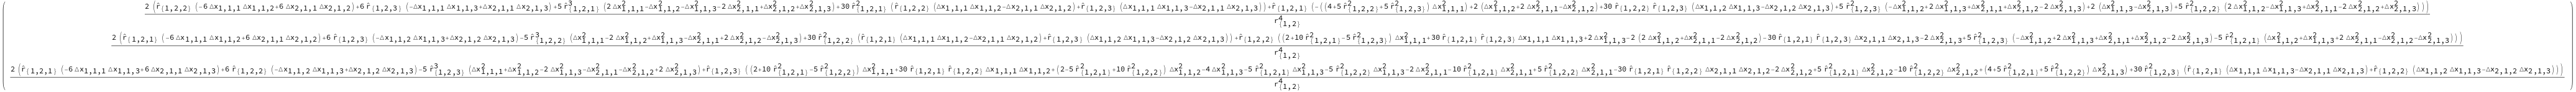

In [705]:
disbalancefM = fMPhantom[Np, 1, 2] + fMPhantom[Np, 2, 1]
disbalancefQ = fQPhantom[Np, 1, 2] + fQPhantom[Np, 2, 1];
ParallelMap[FullSimplify, disbalancefQ] // MatrixForm

##### 2 term disbalance

In [708]:
f2MPhantom[Np, 1, 2]
f2MPhantom[Np, 2, 1]
f2QPhantom[Np, 1, 2]
f2QPhantom[Np, 2, 1]

{0, 0, 0}
{0, 0, 0}
{0, 0, 0}
{0, 0, 0}

##### 3 term disbalance

^         3          2          2
(6 (5 r           (-Δx       + Δx      ) + 
       {1, 2, 1}      1,1,1      2,1,1
 
        ^                    2          ^         2         2
>       r          (3 Δx       + (1 - 5 r          ) Δx       - 
         {1, 2, 1}      1,1,1            {1, 2, 2}     1,1,2
 
              ^          ^                                   ^         2         2
>          10 r          r          Δx      Δx      + (1 - 5 r          ) Δx       - 
               {1, 2, 2}  {1, 2, 3}   1,1,2   1,1,3           {1, 2, 3}     1,1,3
 
                    2           ^         2         2
>          3 Δx       + (-1 + 5 r          ) Δx       + 
               2,1,1             {1, 2, 2}     2,1,2
 
              ^          ^                                    ^         2         2
>          10 r          r          Δx      Δx      + (-1 + 5 r          ) Δx      ) + 
               {1, 2, 2}  {1, 2, 3}   2,1,2   2,1,3            {1, 2, 3}     2,1,3
 
           ^
>       2 (r          (Δx      Δx      - Δx      Δx     ) + 
            {1, 2, 2}    1,1,1   1,1,2     2,1,1   2,1,2
 
           ^
>          r          (Δx      Δx      - Δx      Δx     )) - 
            {1, 2, 3}    1,1,1   1,1,3     2,1,1   2,1,3
 
           ^         2  ^
>       10 r           (r          (Δx      Δx      - Δx      Δx     ) + 
            {1, 2, 1}    {1, 2, 2}    1,1,1   1,1,2     2,1,1   2,1,2
 
           ^                                                          4
>          r          (Δx      Δx      - Δx      Δx     )))) / r
            {1, 2, 3}    1,1,1   1,1,3     2,1,1   2,1,3        {1, 2}

      ^         3          2          2
(6 (5 r           (-Δx       + Δx      ) + 
       {1, 2, 2}      1,1,2      2,1,2
 
        ^                  ^         2         2            2
>       r          ((1 - 5 r          ) Δx       + 3 Δx       - 
         {1, 2, 2}          {1, 2, 1}     1,1,1        1,1,2
 
              ^          ^                                   ^         2         2
>          10 r          r          Δx      Δx      + (1 - 5 r          ) Δx       + 
               {1, 2, 1}  {1, 2, 3}   1,1,1   1,1,3           {1, 2, 3}     1,1,3
 
                   ^         2         2            2
>          (-1 + 5 r          ) Δx       - 3 Δx       + 
                    {1, 2, 1}     2,1,1        2,1,2
 
              ^          ^                                    ^         2         2
>          10 r          r          Δx      Δx      + (-1 + 5 r          ) Δx      ) + 
               {1, 2, 1}  {1, 2, 3}   2,1,1   2,1,3            {1, 2, 3}     2,1,3
 
           ^
>       2 (r          (Δx      Δx      - Δx      Δx     ) + 
            {1, 2, 1}    1,1,1   1,1,2     2,1,1   2,1,2
 
           ^
>          r          (Δx      Δx      - Δx      Δx     )) - 
            {1, 2, 3}    1,1,2   1,1,3     2,1,2   2,1,3
 
           ^         2  ^
>       10 r           (r          (Δx      Δx      - Δx      Δx     ) + 
            {1, 2, 2}    {1, 2, 1}    1,1,1   1,1,2     2,1,1   2,1,2
 
           ^                                                          4
>          r          (Δx      Δx      - Δx      Δx     )))) / r
            {1, 2, 3}    1,1,2   1,1,3     2,1,2   2,1,3        {1, 2}

      ^
(6 (2 r          (Δx      Δx      - Δx      Δx     ) + 
       {1, 2, 1}    1,1,1   1,1,3     2,1,1   2,1,3
 
          ^
>       2 r          (Δx      Δx      - Δx      Δx     ) + 
           {1, 2, 2}    1,1,2   1,1,3     2,1,2   2,1,3
 
        ^                  ^         2         2
>       r          ((1 - 5 r          ) Δx       - 
         {1, 2, 3}          {1, 2, 1}     1,1,1
 
              ^          ^                                   ^         2         2
>          10 r          r          Δx      Δx      + (1 - 5 r          ) Δx       + 
               {1, 2, 1}  {1, 2, 2}   1,1,1   1,1,2           {1, 2, 2}     1,1,2
 
                    2           ^         2         2
>          3 Δx       
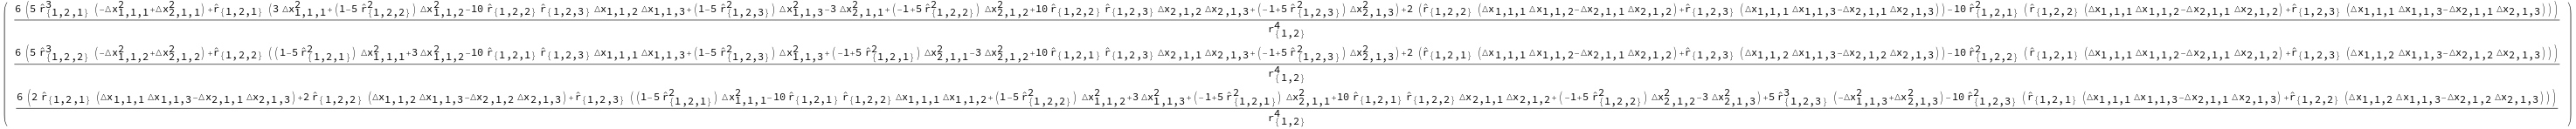
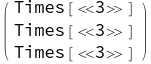

In [713]:
disbalancef3M = f3MPhantom[Np, 1, 2] + f3MPhantom[Np, 2, 1];
ParallelMap[FullSimplify, disbalancef3M] // MatrixForm

disbalancef3Q = f3QPhantom[Np, 1, 2] + f3QPhantom[Np, 2, 1];
ParallelMap[FullSimplify, disbalancef3Q] // MatrixForm

### Conclusion: node-node interaction are <span style="color:green">symmetric</span> up to 1/r^5!

0

0

0
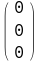

In [716]:
FullSimplify[disbalancefQ + disbalancef3M] // MatrixForm

### Additional force due to disbalance in 1/r^6

2 ^
-20 δy          δy          δy           r
      {1, 1, 1}   {1, 1, 2}   {2, 1, 1}   {1, 2, 1}
--------------------------------------------------- - 
                            2
                     r
                      {1, 2}
 
                                          2 ^
    20 δy          δy          δy           r
         {1, 1, 1}   {1, 1, 3}   {2, 1, 1}   {1, 2, 1}
>   -------------------------------------------------- + 
                                2
                         r
                          {1, 2}
 
                  2                         ^
    20 δy           δy          δy          r
         {1, 1, 1}    {2, 1, 1}   {2, 1, 2}  {1, 2, 1}
>   -------------------------------------------------- - 
                                2
                         r
                          {1, 2}
 
                  2                         ^
    10 δy           δy          δy          r
         {1, 1, 2}    {2, 1, 1}   {2, 1, 2}  {1, 2, 1}
>   -------------------------------------------------- - 
                                2
                         r
                          {1, 2}
 
                  2                         ^
    10 δy           δy          δy          r
         {1, 1, 3}    {2, 1, 1}   {2, 1, 2}  {1, 2, 1}
>   -------------------------------------------------- + 
                                2
                         r
                          {1, 2}
 
                                          2 ^
    10 δy          δy          δy           r
         {1, 1, 1}   {1, 1, 2}   {2, 1, 2}   {1, 2, 1}
>   -------------------------------------------------- + 
                                2
                         r
                          {1, 2}
 
                                          2 ^
    10 δy          δy          δy           r
         {1, 1, 1}   {1, 1, 3}   {2, 1, 2}   {1, 2, 1}
>   -------------------------------------------------- + 
                                2
                         r
                          {1, 2}
 
                  2                         ^
    20 δy           δy          δy          r
         {1, 1, 1}    {2, 1, 1}   {2, 1, 3}  {1, 2, 1}
>   -------------------------------------------------- - 
                                2
                         r
                          {1, 2}
 
                  2                         ^
    10 δy           δy          δy          r
         {1, 1, 2}    {2, 1, 1}   {2, 1, 3}  {1, 2, 1}
>   -------------------------------------------------- - 
                                2
                         r
                          {1, 2}
 
                  2                         ^
    10 δy           δy          δy          r
         {1, 1, 3}    {2, 1, 1}   {2, 1, 3}  {1, 2, 1}
>   -------------------------------------------------- + 
                                2
                         r
                          {1, 2}
 
                                          2 ^
    10 δy          δy          δy           r
         {1, 1, 1}   {1, 1, 2}   {2, 1, 3}   {1, 2, 1}
>   -------------------------------------------------- + 
                                2
                         r
                          {1, 2}
 
                                          2 ^
    10 δy          δy          δy           r
         {1, 1, 1}   {1, 1, 3}   {2, 1, 3}   {1, 2, 1}
>   -------------------------------------------------- - 
                                2
                         r
                          {1, 2}
 
                                          2 ^
    10 δy          δy          δy           r
         {1, 1, 1}   {1, 1, 2}   {2, 1, 1}   {1, 2, 2}
>   -------------------------------------------------- + 
                                2
                         r
                          {1, 2}
 
                  2                         ^
    10 δy           δy          δy          r
         {1, 1, 1}    {2, 1, 1}   {2, 1, 2}  {1, 2, 2}
>  
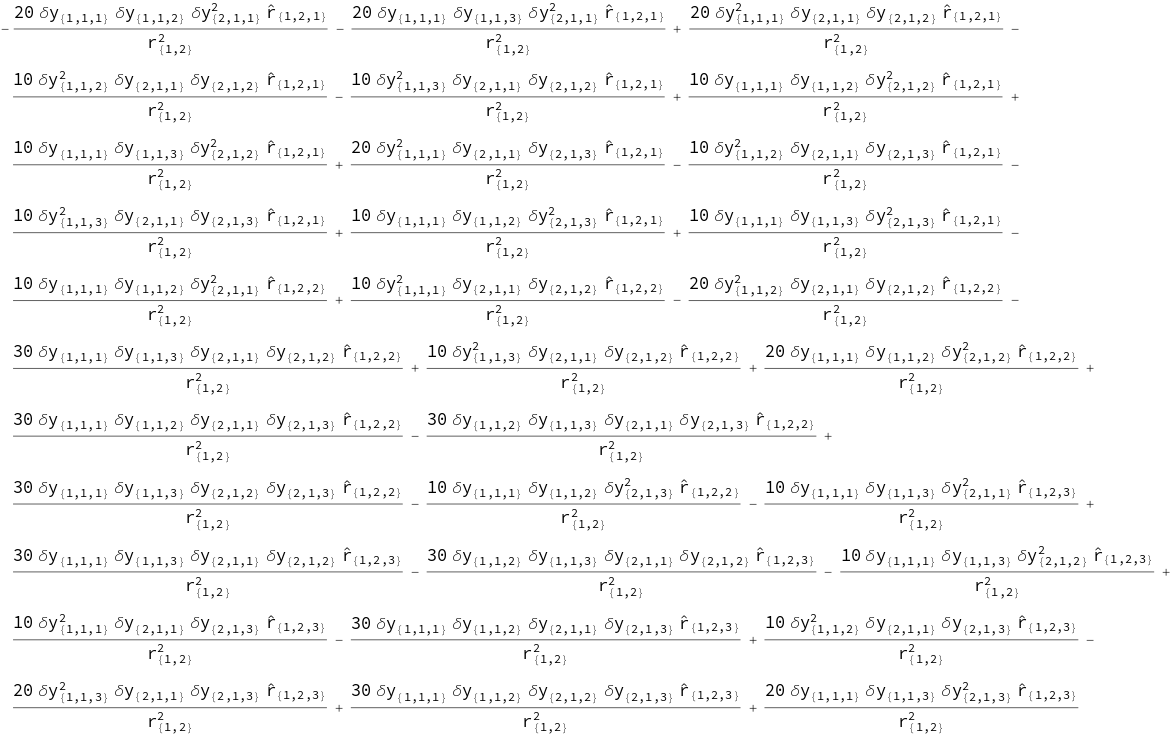

In [719]:
yRules = MapIndexed[
  # -> rnm[[1, 2]]*Subscript[\[Delta]y, Rest[List @@ #1]] &,
  Flatten[Table[dx[[n, 1;;Np[[n]]-1]], {n, 1, Nn}]]
];

disbalancef3Qy = ReplaceAll[
  disbalancef3Q
  , yRules
];

Expand[FullSimplify[disbalancef3Qy[[1]]]] // MatrixForm

## Additional force due to asymmetry of the tree

0





0





0
 





     1





     0





>    0
 
               r       + Δx
                {1, 2}     2,1,1
     -------------------------------------
                 2                      2
     Sqrt[Δx       + (r       + Δx     ) ]
            2,1,1      {1, 2}     2,1,1
                    Δx
                      2,1,1
     -------------------------------------
                 2                      2
     Sqrt[Δx       + (r       + Δx     ) ]
            2,1,1      {1, 2}     2,1,1





>    0
 
                r       - 2 Δx
                 {1, 2}       2,1,1
     -----------------------------------------
                               2            2
     Sqrt[(r       - 2 Δx     )  + 4 Δx      ]
            {1, 2}       2,1,1         2,1,1
                    -2 Δx
                         2,1,1
     -----------------------------------------
                               2            2
     Sqrt[(r       - 2 Δx     )  + 4 Δx      ]
            {1, 2}       2,1,1         2,1,1





>    0






-1





0





0
 





     0





     0





>    0
 



     ^
     r
      {2, 3, 1}



     ^
     r
      {2, 3, 2}





>    0
 



     ^
     r
      {2, 4, 1}



     ^
     r
      {2, 4, 2}





>    0

            r       + Δx
             {1, 2}     2,1,1
-(-------------------------------------)
              2                      2
  Sqrt[Δx       + (r       + Δx     ) ]
         2,1,1      {1, 2}     2,1,1
                 Δx
                   2,1,1
-(-------------------------------------)
              2                      2
  Sqrt[Δx       + (r       + Δx     ) ]
         2,1,1      {1, 2}     2,1,1





0
 



      ^
     -r
       {2, 3, 1}



      ^
     -r
       {2, 3, 2}





>    0
 





     0





     0





>    0
 



     ^
     r
      {3, 4, 1}



     ^
     r
      {3, 4, 2}





>    0

             r       - 2 Δx
              {1, 2}       2,1,1
-(-----------------------------------------)
                            2            2
  Sqrt[(r       - 2 Δx     )  + 4 Δx      ]
         {1, 2}       2,1,1         2,1,1
                2 Δx
                    2,1,1
-----------------------------------------
                          2            2
Sqrt[(r       - 2 Δx     )  + 4 Δx      ]
       {1, 2}       2,1,1         2,1,1





0
 



      ^
     -r
       {2, 4, 1}



      ^
     -r
       {2, 4, 2}





>    0
 



      ^
     -r
       {3, 4, 1}



      ^
     -r
       {3, 4, 2}





>    0
 





     0





     0





>    0
Δx         Δx         Δx
  1,1,1      1,1,2      1,1,3

-Δx        -Δx        -Δx
   1,1,1      1,1,2      1,1,3
Δx           Δx
  2,1,1        2,1,1      0

Δx           Δx
  2,1,1        2,1,1      0

-2 Δx        -2 Δx
     2,1,1        2,1,1   0
0   0   0

0   0   0
0   0   0
{4, 3, 3}

                                            r
0                                            {1, 2}
 
                    2                      2
        Sqrt[Δx       + (r       + Δx     ) ]
>              2,1,1      {1, 2}     2,1,1
 
                               2            2
     Sqrt[(r       - 2 Δx     )  + 4 Δx      ]
>           {1, 2}       2,1,1         2,1,1


r
 {1, 2}                                     0
 

        r
>        {2, 3}
 

     r
>     {2, 4}

            2                      2
Sqrt[Δx       + (r       + Δx     ) ]       r
       2,1,1      {1, 2}     2,1,1           {2, 3}
 


>       0
 

     r
>     {3, 4}

                          2            2
Sqrt[(r       - 2 Δx     )  + 4 Δx      ]   r
       {1, 2}       2,1,1         2,1,1      {2, 4}
 

        r
>        {3, 4}
 


>    0
         2            2            2
4 Δx       - 2 Δx       - 2 Δx          6 Δx      Δx
    1,1,1        1,1,2        1,1,3         1,1,1   1,1,2
 

     6 Δx      Δx
>        1,1,1   1,1,3

                                                  2            2            2
6 Δx      Δx                            -2 Δx       + 4 Δx       - 2 Δx

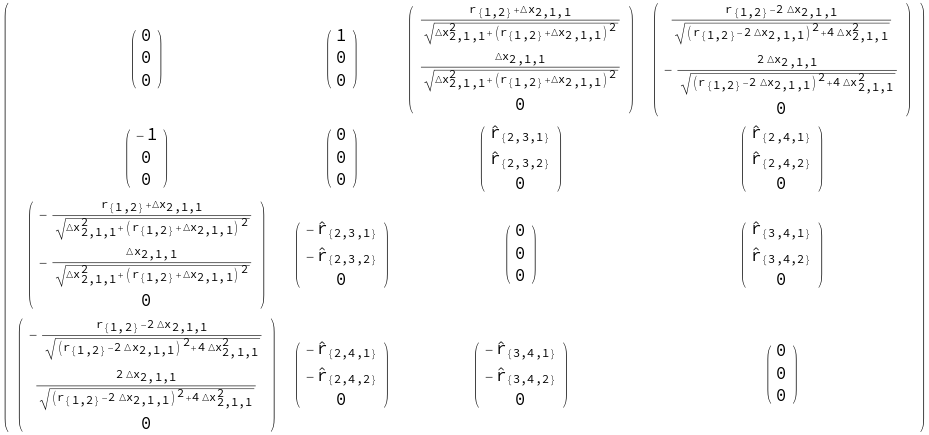
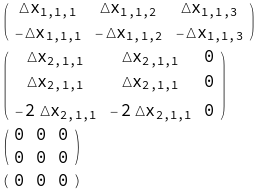
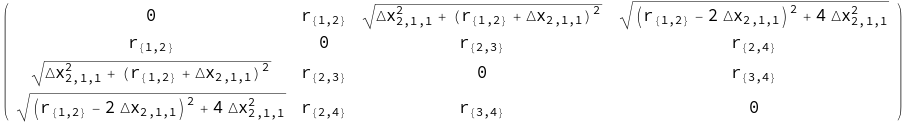
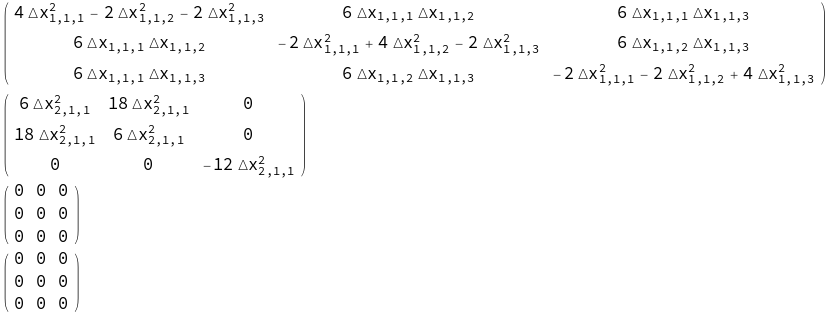
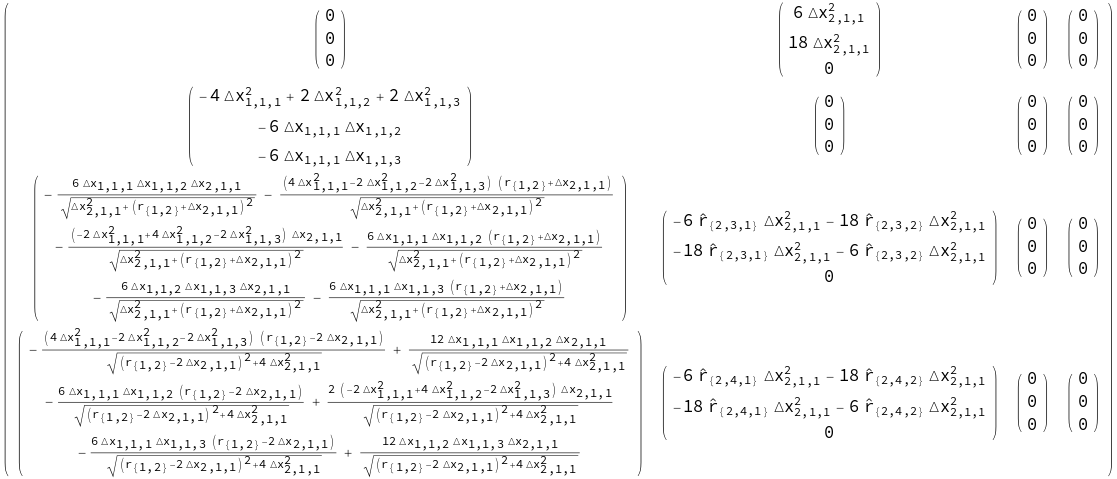
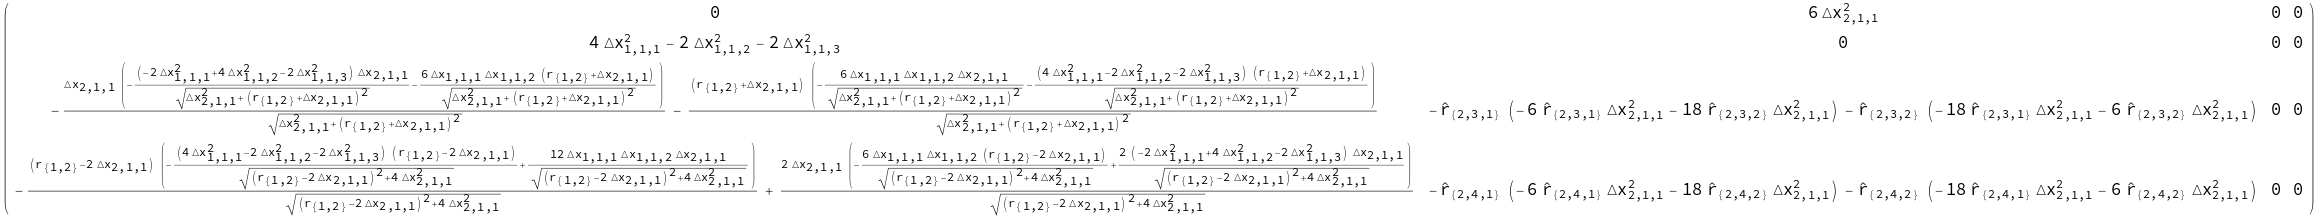

In [748]:
(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

(* system of 4 nodes
A <- B(b1, b2)
b1 <- A
b2 <- A *)
(* Np = {A, B, b1, b2}; *)
Np = {2, 3, 2, 1};
(* number of nodes *)
Nn = Length[Np];
(* maximum number of paticles *)
maxNp = Max[Np];

dx = DefineDx[Np];
rAll = DefineR[Np];
rnm = rAll[[1]];
urh = rAll[[2]];

yRules = MapIndexed[
  # -> rnm[[1, 2]]*Subscript[\[Delta]y, Rest[List @@ #1]] &,
  Flatten[Table[dx[[n, 1;;Np[[n]]-1]], {n, 1, Nn}]]
];

(* Simplification *)

(* 3,4 subnodes are collapsed to dots *)
dx[[3;;4, All, All]] = 0;
(* supernode 2 *)
dx[[2;;4, All, 3]] = 0;
(* unit r *)
urh[[All, All, 3]] = 0;
urh[[1, 2, 1]] = 1;
urh[[2, 1, 1]] = -1;
urh[[1;;2, 1;;2, 2]] = 0;

case = 3;

If[case == 1,
(
(* 1 case: Assume all nodes are along the x axis *)
(* 1 subnodes are collapsed to dots *)
(* only 1 term in eq. 228 does not equal to zero *)
(* dx[[1, All, All]] = 0; *)
(*supernode 2 *)
dx[[2, 1;;Np[[3]], 1]] = dx[[2, 1, 1]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], 1]] = -dx[[2, 1, 1]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
dx[[2, All, 2]] = 0;
(* distance between nodes *)
rnm[[1, 3]] = rnm[[1, 2]] + dx[[2, 1, 1]];
rnm[[1, 4]] = rnm[[1, 2]] + dx[[2, Np[[2]], 1]];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]];
(* unit r *)
urh[[All, All, 2]] = 0;
Do[urh[[n, m, 1]] = 1, {n, 1, Length[Np]}, {m, n + 1, Length[Np]}];
Do[urh[[n, m, 1]] = -1, {m, 1, Length[Np]}, {n, m + 1, Length[Np]}];
)
]

If[case == 2,
(
(* 2 case: 1, 2 nodes are along the x axis
  but 3, 4 subnodes of supernode 2 are along the y axis *)
(* 1 subnodes are collapsed to dots *)
(* only 1 term in eq. 228 does not equal to zero *)
(* dx[[1, All, All]] = 0; *)
(*supernode 2 *)
dx[[2, 1;;Np[[3]], 2]] = dx[[2, 1, 2]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], 2]] = -dx[[2, 1, 2]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
dx[[2, All, 1]] = 0;
(* distance between nodes *)
rnm[[1, 3]] = Sqrt[rnm[[1, 2]]^2 + dx[[2, 1, 2]]^2];
rnm[[1, 4]] = Sqrt[rnm[[1, 2]]^2 + dx[[2, Np[[2]], 2]]^2];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]];
(* unit r *)
urh[[1, 3, 1]] = rnm[[1, 2]]/rnm[[1, 3]];
urh[[1, 3, 2]] = dx[[2, 1, 2]]/rnm[[1, 3]];
urh[[3, 1, All]] = -urh[[1, 3, All]];
urh[[1, 4, 1]] = rnm[[1, 2]]/rnm[[1, 4]];
urh[[1, 4, 2]] = dx[[2, Np[[2]], 2]]/rnm[[1, 4]];
urh[[4, 1, All]] = -urh[[1, 4, All]];
)
]

If[case == 3,
(
(* 3 case: 1, 2 nodes are along the x axis
  but 3, 4 subnodes of supernode 2 are located at an angle to the x and y axes *)
(* 1 subnodes are collapsed to dots *)
(* only 1 term in eq. 228 does not equal to zero *)
(* dx[[1, All, All]] = 0; *)
(*supernode 2 *)
dx[[2, 1;;Np[[3]], {1,2}]] = dx[[2, 1, 1]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], {1,2}]] = -dx[[2, 1, 1]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
(* distance between nodes *)
rnm[[1, 3]] = Sqrt[(rnm[[1, 2]] + dx[[2, 1, 1]])^2 + dx[[2, 1, 2]]^2];
rnm[[1, 4]] = Sqrt[(rnm[[1, 2]] + dx[[2, Np[[2]], 1]])^2 + dx[[2, Np[[2]], 2]]^2];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]];
(* unit r *)
urh[[1, 3, 1]] = (rnm[[1, 2]] + dx[[2, 1, 1]])/rnm[[1, 3]];
urh[[1, 3, 2]] = dx[[2, 1, 2]]/rnm[[1, 3]];
urh[[3, 1, All]] = -urh[[1, 3, All]];

urh[[1, 4, 1]] = (rnm[[1, 2]] + dx[[2, Np[[2]], 1]])/rnm[[1, 4]];
urh[[1, 4, 2]] = dx[[2, Np[[2]], 2]]/rnm[[1, 4]];
urh[[4, 1, All]] = -urh[[1, 4, All]];
)
]

urh //MatrixForm

Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]
(* node n, p from n, components dx *)
Dimensions[dx]
(* node n, node m *)
rnm // MatrixForm

QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]
(* node n, components q, components q *)
Dimensions[Qij]

Qi = QijAll[[2]];
Qi // MatrixForm
(* node n, components q *)
Dimensions[Qi]

Q = QijAll[[3]];
Q // MatrixForm
(* node n *)
Dimensions[Q]

-6
--------
       2
r
 {1, 2}





0





0
               2
-18 δy
      {2, 1, 1}                  4
---------------- + O[δy         ]
           2           {2, 1, 1}
    r
     {1, 2}

              2
36 δy
     {2, 1, 1}                  4
--------------- + O[δy         ]
          2           {2, 1, 1}
   r
    {1, 2}







0
0

0

0
0

0

0
             2            2            2            2            2            2
-3 (6 r        δy           - 3 r        δy           - 3 r        δy          )
       {1, 2}    {1, 1, 1}       {1, 2}    {1, 1, 2}       {1, 2}    {1, 1, 3}
--------------------------------------------------------------------------------
                                           4
                                    r
                                     {1, 2}


18 δy          δy
     {1, 1, 1}   {1, 1, 2}
--------------------------
                2
         r
          {1, 2}


18 δy          δy
     {1, 1, 1}   {1, 1, 3}
--------------------------
                2
         r
          {1, 2}
                    2                                             2
(-15 (12 δy           - 52 δy          δy          - 3 δy           + 
           {1, 1, 1}         {1, 1, 1}   {1, 1, 2}       {1, 1, 2}
 
                                                  2             2           2
>        2 δy          δy          - 9 δy          ) δy          ) / r        + 
             {1, 1, 1}   {1, 1, 3}       {1, 1, 3}     {2, 1, 1}      {1, 2}
 
                  4
>   O[δy         ]
        {2, 1, 1}

                   2                                          2
(30 (12 δy           + δy          δy          - 9 δy           - 
          {1, 1, 1}      {1, 1, 1}   {1, 1, 2}       {1, 1, 2}
 
                                                  2             2           2
>        3 δy          δy          - 3 δy          ) δy          ) / r        + 
             {1, 1, 2}   {1, 1, 3}       {1, 1, 3}     {2, 1, 1}      {1, 2}
 
                  4
>   O[δy         ]
        {2, 1, 1}

                                                                       2
30 (10 δy          δy          - 3 δy          δy         ) δy
         {1, 1, 1}   {1, 1, 3}       {1, 1, 2}   {1, 1, 3}    {2, 1, 1}
------------------------------------------------------------------------ + 
                                       2
                                r
                                 {1, 2}
 
                  4
>   O[δy         ]
        {2, 1, 1}
                                                             2
  4 r           8 r       δy            6 r       δy
     {1, 2}        {1, 2}   {2, 1, 1}      {1, 2}   {2, 1, 1}
------------- - --------------------- + ---------------------- + 
        2 3/2               2 3/2                   2 3/2
(r       )          (r       )              (r       )
  {1, 2}              {1, 2}                  {1, 2}
 
                         3
    8 r       δy
       {1, 2}   {2, 1, 1}                  4
>   ---------------------- + O[δy         ]
                2 3/2            {2, 1, 1}
        (r       )
          {1, 2}

                                              2                         3
4 r       δy            12 r       δy             18 r       δy
   {1, 2}   {2, 1, 1}       {1, 2}   {2, 1, 1}        {1, 2}   {2, 1, 1}
--------------------- - ----------------------- + ----------------------- + 
            2 3/2                    2 3/2                     2 3/2
    (r       )               (r       )                (r       )
      {1, 2}                   {1, 2}                    {1, 2}
 
                  4
>   O[δy         ]
        {2, 1, 1}

0
                2              2              2
6 (2 δy           - δy           - δy          )
       {1, 1, 1}      {1, 1, 2}      {1, 1, 3}
------------------------------------------------ - 
                                 2
             r       Sqrt[r       ]
              {1, 2}       {1, 2}
 
                      2      
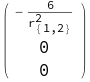
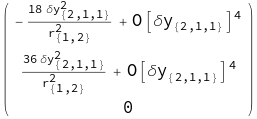
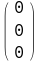
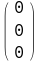
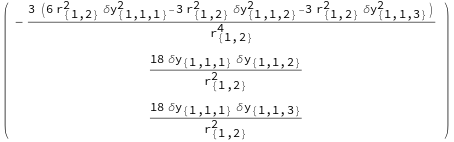
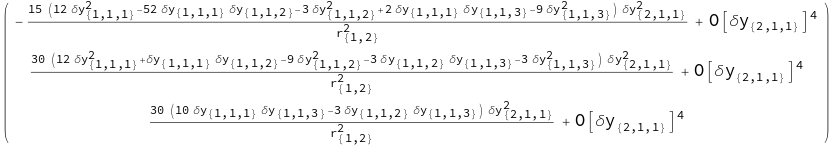
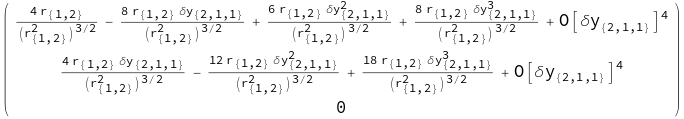
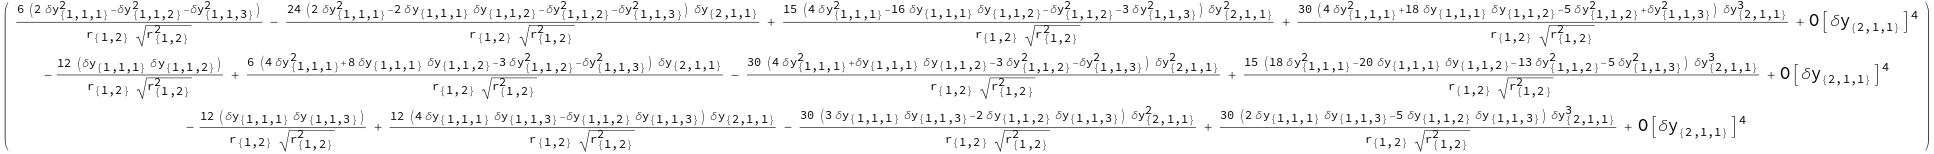
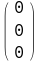
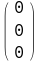
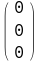
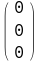
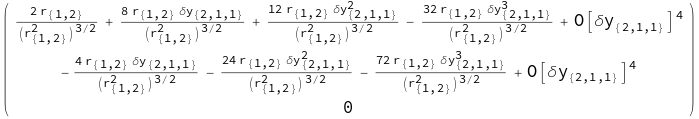
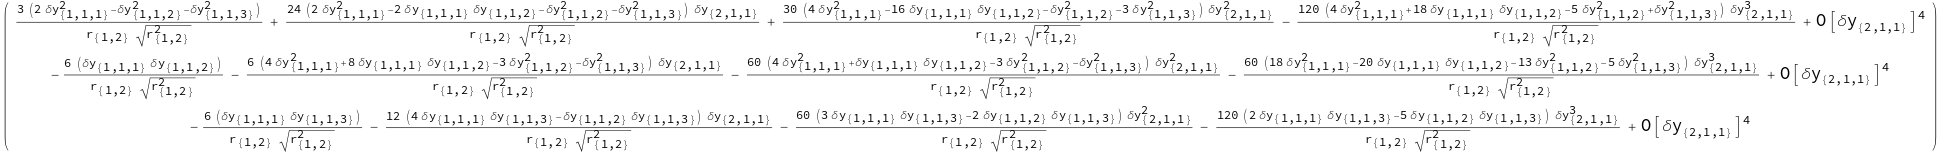
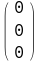
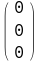
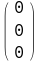
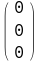

In [768]:
YTaylorExpansion[force_] := ParallelMap[
  Series[#,
    Which[
      case == 1,
      {Subscript[\[Delta]y, {2, 1, 1}], 0, 3},
      case == 2,
      {Subscript[\[Delta]y, {2, 1, 2}], 0, 3},
      case == 3,
      {Subscript[\[Delta]y, {2, 1, 1}], 0, 3}
    ]
  ]
  &,
  ReplaceAll[
    force
    , yRules
  ]
]

YTaylorExpansion[fMPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[fQPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[f2MPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[f2QPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[f3MPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[f3QPhantom[Np, 1, 2]] // MatrixForm

YTaylorExpansion[fMPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[fQPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[f2MPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[f2QPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[f3MPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[f3QPhantom[Np, 3, 1]] // MatrixForm

YTaylorExpansion[fMPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[fQPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[f2MPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[f2QPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[f3MPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[f3QPhantom[Np, 4, 1]] // MatrixForm

2
-30 δy          (-2 δy          + δy         ) δy
      {1, 1, 1}       {1, 1, 2}     {1, 1, 3}    {2, 1, 1}
----------------------------------------------------------- - 
                                2
                         r
                          {1, 2}
 
                          2                                               2
>   (6 (4 + 60 δy           + 270 δy          δy          - 75 δy           + 
                 {1, 1, 1}          {1, 1, 1}   {1, 1, 2}        {1, 1, 2}
 
                       2             3           2                 4
>        15 δy          ) δy          ) / r        + O[δy         ]
              {1, 1, 3}     {2, 1, 1}      {1, 2}        {2, 1, 1}

                                                           2
-30 δy          (2 δy          + 3 δy         ) δy
      {1, 1, 2}      {1, 1, 1}       {1, 1, 3}    {2, 1, 1}
------------------------------------------------------------ + 
                                 2
                          r
                           {1, 2}
 
                           2                                               2
>   (9 (-6 - 90 δy           + 100 δy          δy          + 65 δy           + 
                  {1, 1, 1}          {1, 1, 1}   {1, 1, 2}        {1, 1, 2}
 
                       2             3           2                 4
>        25 δy          ) δy          ) / r        + O[δy         ]
              {1, 1, 3}     {2, 1, 1}      {1, 2}        {2, 1, 1}

                                                        2
30 (δy          + 3 δy         ) δy          δy
      {1, 1, 1}       {1, 1, 2}    {1, 1, 3}   {2, 1, 1}
--------------------------------------------------------- + 
                               2
                        r
                         {1, 2}
 
                                                               3
    90 (-2 δy          + 5 δy         ) δy          δy
             {1, 1, 1}       {1, 1, 2}    {1, 1, 3}   {2, 1, 1}                  4
>   ------------------------------------------------------------ + O[δy         ]
                                     2                                 {2, 1, 1}
                              r
                               {1, 2}
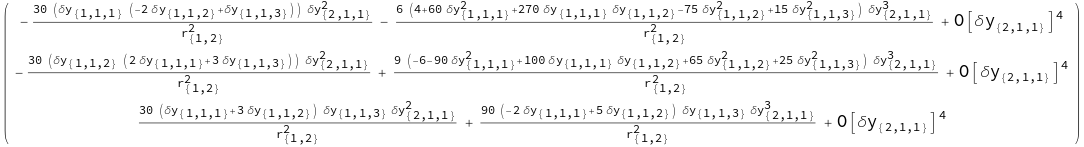

In [790]:
fAFromB = (fMPhantom[Np, 1, 2] + fQPhantom[Np, 1, 2]
  + f2MPhantom[Np, 1, 2] + f2QPhantom[Np, 1, 2]
  + f3MPhantom[Np, 1, 2] + f3QPhantom[Np, 1, 2]);
fb1FromA = (fMPhantom[Np, 3, 1] + fQPhantom[Np, 3, 1]
  + f2MPhantom[Np, 3, 1] + f2QPhantom[Np, 3, 1]
  + f3MPhantom[Np, 3, 1] + f3QPhantom[Np, 3, 1]);
fb2FromA = (fMPhantom[Np, 4, 1] + fQPhantom[Np, 4, 1]
  + f2MPhantom[Np, 4, 1] + f2QPhantom[Np, 4, 1]
  + f3MPhantom[Np, 4, 1] + f3QPhantom[Np, 4, 1]);

F = YTaylorExpansion[fAFromB + fb1FromA + fb2FromA];
FullSimplify[F] // MatrixForm

{1, 2, 1, 1}
              4
10 δy
     {2, 1, 1}
---------------
          2
   r
    {1, 2}
{1, 3, 2, 1}
              3
24 δy
     {2, 1, 1}
---------------
          2
   r
    {1, 2}
{1, 3, 1, 2}
              3
-3 δy
     {2, 1, 1}
---------------
          2
   r
    {1, 2}
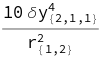
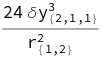
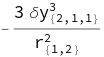

In [792]:
(* case 1 *)
Np = {1, 2, 1, 1}
addForce = 10*Subscript[\[Delta]y, {2,1,1}]^4/Subscript[r, {1,2}]^2
Np = {1, 3, 2, 1}
addForce = 24*Subscript[\[Delta]y, {2,1,1}]^3/Subscript[r, {1,2}]^2
Np = {1, 3, 1, 2}
addForce = -3*Subscript[\[Delta]y, {2,1,1}]^3/Subscript[r, {1,2}]^2

{1, 2, 1, 1}
              4
15 δy
     {2, 1, 1}
---------------
           2
  4 r
     {1, 2}
{1, 3, 2, 1}
             3
9 δy
    {2, 1, 1}
--------------
          2
   r
    {1, 2}
{1, 3, 1, 2}
             3
9 δy
    {2, 1, 2}
--------------
           2
  8 r
     {1, 2}
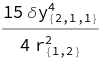
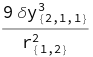
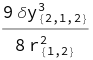

In [799]:
(* case 2 *)
Np = {1, 2, 1, 1}
addForce = 15*Subscript[\[Delta]y, {2,1,1}]^4/(4*Subscript[r, {1,2}]^2)
Np = {1, 3, 2, 1}
addForce = 9*Subscript[\[Delta]y, {2,1,1}]^3/Subscript[r, {1,2}]^2
Np = {1, 3, 1, 2}
addForce = 9*Subscript[\[Delta]y, {2,1,2}]^3/(8*Subscript[r, {1,2}]^2)

3
Δx
---
 5
r
    3
T Δx
-----
   5
n r
    3
T Δx
------
   5
n r  μ
          3
  2     Δx
 T  Abs[----]
         5
        r  μ
---------------
Sqrt[3] Sqrt[n]
          1/4  1/4                   1/4  1/4
         3    n    Sqrt[r]          3    n    Sqrt[r]
{{T -> -(-----------------)}, {T -> -----------------}}
                     3                          3
                   Δx                         Δx
          Sqrt[Abs[----]]            Sqrt[Abs[----]]
                    5                          5
                   r  μ                       r  μ
 1/4  1/4  3       μ
3    n    r  Sqrt[---]
                    3
                  Δx
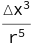
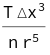
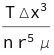
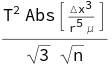
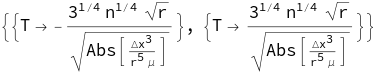
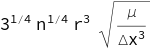

In [809]:
if[Length[Names["Global`*"]] > 0, Remove["Global`*"]];

$Assumptions = {
  _ \[Element] PositiveReals
};

F = \[CapitalDelta]x^3/(r^5)
\[CapitalDelta]p = F*\[Tau]
v = \[CapitalDelta]p/\[Mu]
\[Tau] = T/n;
\[CapitalDelta]y = FullSimplify[Sqrt[1/3*v^2*\[Tau]^2*n^3]]
(* sol = Solve[r == \[CapitalDelta]y, n] *)
(* FullSimplify[n /. sol, {\[CapitalDelta]x > 0, r > 0, \[Mu] > 0, T > 0}] *)
sol = Solve[r == \[CapitalDelta]y, T]
Tsol = FullSimplify[T /. sol[[2]], {\[CapitalDelta]x > 0, r > 0, \[Mu] > 0, n > 0, G > 0}]


1
-----
10000
1
              1/4  1/4
1000 Sqrt[2] 3    n
-Graphics-
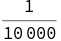
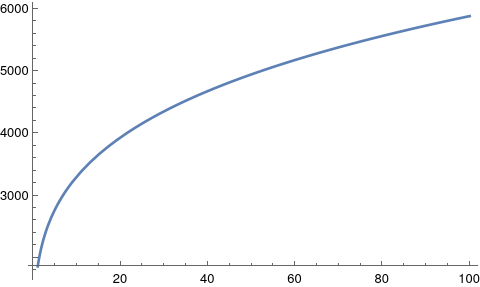

In [821]:
G = 6.67 * 10^(-8);
\[Mu] = 10*20/10^4*M/10^4;
M = 1;
\[CapitalDelta]x = 10^(-4)
r = 1
Tsol
Plot[Tsol,{n, 1, 10^2}]